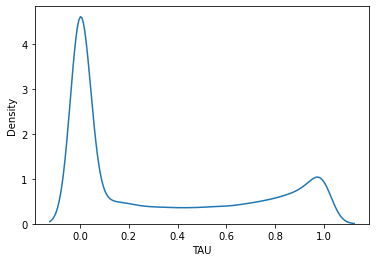

In [51]:
## 分析组织特异性低表达基因
import pandas as pd
import numpy as np
import seaborn as sns
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/PCA/J668_all_tissue_average_TPM.txt", sep='\t')
## 数据调整，对表达水平加 0.5并取倒数
tissues = ['anthers', 'cotyledon', 'ovules',  'hypocotyl', 'leaf', 'petals', 'radicle', 'root', 'stem', 'stigma', 'fiber_5DPA', 'fiber_10DPA', 'fiber_20DPA']
## 数据调整
def data_adjust(df):
    #df_TPM = df[tissues].copy()
    df_nozero = df.loc[~(df[tissues]==0).all(axis=1), :] # 去除全部等于0的行
    df_GeneId = df_nozero[['GeneId', 'chr', 'start', 'end']].copy()
    df_TPM = df_nozero[tissues].copy()
    df_TPM = df_TPM+0.5 #给每个基因加上基础值
    df_TPM = 1/df_TPM # 给TPM取倒数
    df_TPM[df_TPM<=1] = 1 
    for t in tissues:
        df_TPM[t] = df_TPM[t].apply(np.log)
    df_return = pd.concat([df_GeneId, df_TPM], axis=1)
    df_return.replace(0, 0.0001, inplace=True)
    return df_return
## 数据计算
def TAU(df):
    for index, row in df.iterrows():
        n = 13 ## The number of tissues
        tissue_tpm = sorted(row[4:17])
        tau = n/(n-1) - sum(tissue_tpm)/((n-1)*max(tissue_tpm)) # Calculate the tau
        df.loc[index, 'TAU'] = tau
    sns.kdeplot(data=df["TAU"])
    df['tissues'] = df[tissues].idxmax(axis=1)#给一行最大值加上标签
    df_return = df.query("TAU>=0.8")
    return df_return
df_adjust = data_adjust(df)
df_tau = TAU(df_adjust)
df_tau.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/J668_TAU_adjustTPM_low.bed", sep="\t", index=False)

In [52]:
## 将数据校正过的值替换为TPM值
df_adjust = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/J668_TAU_adjustTPM_low.bed", sep="\t")
df_adjust = df_adjust[['GeneId', 'TAU', 'tissues']]
df_TPM = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/PCA/J668_all_tissue_average_TPM.txt", sep="\t")
df_result = pd.merge(df_adjust, df_TPM, how='inner', on=['GeneId'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/J668_TAU_TPM_low.bed", sep="\t", index=False)

In [ ]:
## 对于TMP 值进行z-score 标准化
import pandas as pd
import scipy.stats as stats
tissues = ['anthers', 'cotyledon', 'ovules',  'hypocotyl', 'leaf', 'petals', 'radicle', 'root', 'stem', 'stigma', 'fiber_5DPA', 'fiber_10DPA', 'fiber_20DPA']
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/J668_TAU_TPM_low.bed", sep="\t")
def TPM_zscore(df):
    df_tags = df[['GeneId', 'tissues']].copy()
    df_TPM = df[tissues].copy()
    np_TPM = df_TPM.to_numpy()
    np_TPM_zscore = stats.zscore(np_TPM, axis=1) # 数据标准化
    df_TPM_zscore = pd.DataFrame(np_TPM_zscore, columns=tissues)
    df_result = pd.concat([df_tags, df_TPM_zscore], axis=1)
    return df_result
df_result = TPM_zscore(df)
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/zscore/J668_TAU_TPM_low_zscore.bed", sep="\t", index=False)

In [13]:
## 将标准化的数据归一化
import pandas as pd
import numpy as np
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/zscore/J668_TAU_TPM_low_zscore.bed", sep="\t")
tissues = ['anthers', 'cotyledon', 'ovules',  'hypocotyl', 'leaf', 'petals', 'radicle', 'root', 'stem', 'stigma', 'fiber_5DPA', 'fiber_10DPA', 'fiber_20DPA']
def Normalization2(x): # 数据归一化
    return [(float(i)-np.mean(x))/(max(x)-min(x)) for i in x]
## 数据批量标准化
print(df.shape)
df_tmp = pd.DataFrame(columns=['GeneId', 'tags', 'anthers', 'cotyledon', 'ovules',  'hypocotyl', 'leaf', 'petals', 'radicle', 'root', 'stem', 'stigma', 'fiber_5DPA', 'fiber_10DPA', 'fiber_20DPA'])
for index, row in df.iterrows():
    data = row[tissues]
    geneid , tags = [row['GeneId']], [row['tissues']]
    data_normal = Normalization2(data)
    row_new = geneid + tags + data_normal 
    df_tmp.loc[df_tmp.shape[0],] = row_new 
## 写出到文件
for t in tissues:
    df_tissues = df_tmp.query("tags==@t")
    print(t, df_tissues.shape[0])
    output_f = "G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_low/zscore/{}_zscore_normal.bed".format(t)
    df_tissues.to_csv(output_f, sep="\t", index=False, columns=['GeneId', 'anthers', 'leaf', 'hypocotyl', 'cotyledon',  'stem', 'root', 'radicle', 'ovules', 'fiber_5DPA', 'fiber_10DPA', 'fiber_20DPA', 'petals', 'stigma'])

(13246, 15)
anthers 2004
cotyledon 803
ovules 469
hypocotyl 82
leaf 325
petals 2301
radicle 226
root 422
stem 69
stigma 593
fiber_5DPA 129
fiber_10DPA 1436
fiber_20DPA 4387


In [ ]:
## 分析胚珠组织特异性基因，能否和突变体库有overlap
import pandas as pd
df_TAU = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/J668_tissue_special_gene_long.bed", sep="\t")
df_TAU_ovules = df_TAU.query("special_tissues == 'ovules'").copy()
df_TAU_ovules.drop_duplicates(keep='first', inplace=True, subset=['GeneId'])
df_TF = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/fname.bed", sep="\t", names=['TF_ID'])
df_TF[['one', 'two', 'three']] = df_TF['TF_ID'].str.split("-", expand=True)
df_TF['TF_ID'] = df_TF['one'] + '-' + df_TF['two']
df_TF = df_TF['TF_ID'].copy()
df_TF.drop_duplicates(keep='first', inplace=True)
# print(df_TF)
df_mutate_ovules = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/Mutate_gene.txt", sep="\t")
df_mutate = pd.merge(df_mutate_ovules, df_TF, how='inner', on=['TF_ID'])
print(df_mutate)
df_result = pd.merge(df_TAU_ovules, df_mutate, how='inner', on=['GeneId'])
print(df_result)

In [38]:
import pandas as pd
df_mutate = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/Mutate_gene.txt", sep="\t")
df_TAU = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/J668_tissue_special_gene_long.bed", sep="\t")
df_TAU_ovules = df_TAU.query("special_tissues == 'ovules'").copy()
df_TAU_ovules.drop_duplicates(keep='first', inplace=True, subset=['GeneId'])
df_tair = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_vs_Arabidopsis.txt", sep="\t", names=['GeneId', 'TairId'])
df_mutate_tau = pd.merge(df_mutate, df_TAU_ovules, how='inner', on=['GeneId'])
df_result = pd.merge(df_mutate_tau, df_tair, how='inner', on=['GeneId'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/TAU_mutate.bed", sep="\t", index=False)
df_result.head()

,TF_ID,GeneId,Name,Family,Arabidopsis_homologs,chr,start,end,special_tissues,tissues,TPM,TairId
0,TF-3,Ghir_A11G009000,AGL6_A11,MIKC_MADS,AT2G45650.1,Ghir_A11,8053282,8056895,ovules,anthers,1.585893,AT2G45650
1,TF-4,Ghir_A07G015380,AGL6_A07,MIKC_MADS,AT2G45650.1,Ghir_A07,33903978,33909691,ovules,anthers,0.012189,AT2G45650
2,TF-7,Ghir_A02G017610,VRN1_A02,B3,AT3G18990.1,Ghir_A02,106389509,106392520,ovules,anthers,0.000000,AT3G18990
3,TF-44,Ghir_A05G024090,ARR12_A05,ARR-B,AT2G25180.1,Ghir_A05,23979759,23984631,ovules,anthers,0.457845,AT3G57040
4,TF-64,Ghir_D11G022110,bHLH093_D11,bHLH,AT5G65640.1,Ghir_D11,30345111,30355572,ovules,anthers,0.000000,AT5G65640


In [44]:
## 分析突变体库中所有基因其基因表达水平变化
import pandas as pd
import seaborn as sn
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/expression_gene/J668_all_tissue_average_TPM.txt", sep="\t")
## 已经敲除的基因，TF名称
df_TF = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/fname.bed", sep="\t", names=['TF_ID'])
df_TF[['one', 'two', 'three']] = df_TF['TF_ID'].str.split("-", expand=True)
df_TF['TF_ID'] = df_TF['one'] + '-' + df_TF['two']
df_TF = df_TF['TF_ID'].copy()
df_TF.drop_duplicates(keep='first', inplace=True)

## 将TF名称转换为基因名称
df_gene = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/Mutate_gene.txt", sep="\t")
df_mutant = pd.merge(df_TF, df_gene , how='inner', on=['TF_ID'])
df_mutant = df_mutant[['GeneId', 'TF_ID']]

df_result = pd.merge(df, df_mutant, how='inner', on=['GeneId'])
df_result = df_result[['GeneId', 'Anther', 'Leaf', 'Hypocotyl', 'Cotyledon', 'Stem', 'Ovule', 'Root', 'Radicle', 'Fiber_5DPA', 'Fiber_10DPA', 'Fiber_20DPA', 'Petal', 'Stigma']]
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/mutant_gene_tissues_TAU.bed", sep="\t", index=False)

In [48]:
## 找到已经突变基因的位置
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/mutant_gene_tissues_TAU.bed", sep="\t")
df_position = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_gene_position.bed", sep="\t")
df_result = pd.merge(df_position, df, how='inner', on=['GeneId'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/mutants/mutant_gene_tissues_position.bed", sep="\t", index=False, columns=['chr', 'start', 'end', 'GeneId'], header=False)

In [15]:
## 分析TAU与HG 之间的联系
## 分析同源基因对之间 TAU 值，TAU 特异组织情况,
## 之前的老数据
import pandas as pd
df_TAU = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/J668_tau_tags.txt", sep="\t")
df_HG = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/homo_gene2/Ghir_homo_gene_pairs.txt", sep="\t")
df_TAU = df_TAU[['GeneId', 'TAU', 'TAU_Tags']].copy()
## At add TAU tags
df_TAU.columns = ['GeneId_At', 'TAU_At', 'TAU_Tags_At']
df_At = pd.merge(df_HG, df_TAU, how='left', on=['GeneId_At'])
## Dt add TAU tags
df_TAU.columns = ['GeneId_Dt', 'TAU_Dt', 'TAU_Tags_Dt']
df_AtDt = pd.merge(df_At, df_TAU, how='left', on=['GeneId_Dt'])
#print(df_AtDt.head())
# 1.1、两个同源基因都被认为是TSG同时在一个组织中, Both TSG Strength
df_Both_TSG_s1 = df_AtDt.query("TAU_At>=0.85 & TAU_Dt>=0.85 & TAU_Tags_At==TAU_Tags_Dt").copy()
# 1.2、两个同源基因其中有一个TSG>=0.85 另外一个TSG>=0.75 & TSG<0.85 并且同时都在一个组织中, Both TSG weak
df_Both_TSG_s2 = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt>=0.75 & TAU_Dt<0.85) | (TAU_At<0.85 & TAU_At>=0.75 & TAU_Dt>=0.85)) & TAU_Tags_At==TAU_Tags_Dt").copy()
# 1、两个同源基因被认为是TSG，并且能在同一组织中
df_Both_TSG_s = pd.concat([df_Both_TSG_s1, df_Both_TSG_s2], axis=0)
df_Both_TSG_s['T'] = ['Both_same']*df_Both_TSG_s.shape[0]
# 2.1、两个同源基因都被认为是TSG，但是分别在不同组织中 Both TSG Other
df_Both_TSG_o1 = df_AtDt.query("TAU_At>=0.85 & TAU_Dt>=0.85 & TAU_Tags_At!=TAU_Tags_Dt").copy()
# 2.2、两个同源基因其中有一个TSG>=0.85 另外一个TSG>=0.75 & TSG<0.85 并且不在同一个组织中, Both TSG weak
df_Both_TSG_o2 = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt>=0.75 & TAU_Dt<0.85) | (TAU_At<0.85 & TAU_At>=0.75 & TAU_Dt>=0.85)) & TAU_Tags_At!=TAU_Tags_Dt").copy()
# 2、两个同源基因被认为是TSG，并且不位于同一组织
df_Both_TSG_o = pd.concat([df_Both_TSG_o1, df_Both_TSG_o2], axis=0)
df_Both_TSG_o['T'] = ['Both_other']*df_Both_TSG_o.shape[0]
# 3、两个同源基因有一个被认为是TSG， 另一个在多个组织中表达, Sigle TSG high expression
df_Single_TSG_h = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt<0.75 & TAU_Dt>=0.0000001) | (TAU_At<0.75 & TAU_At > 0.0000001 & TAU_Dt>=0.85))").copy()
df_Single_TSG_h['T'] = ['Single_same']*df_Single_TSG_h.shape[0]
# 4、两个同源基因有一个被认为是TSG， 另一个基本不表达, Sigle TSG low expression
df_Single_TSG_l = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt<0.0000001) | (TAU_At<0.0000001 & TAU_Dt>=0.85))").copy()
df_Single_TSG_l['T'] = ['Single_other']*df_Single_TSG_l.shape[0]
df_TAU_true = df_AtDt.query("TAU_At>=0.85|TAU_Dt>=0.85")
df_result = pd.concat([df_Both_TSG_s, df_Both_TSG_o, df_Single_TSG_h, df_Single_TSG_l], axis=0)
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/TSG_HG_diff_type.bed", sep="\t", index=False)
print(df_Both_TSG_s.shape[0],  df_Both_TSG_o.shape[0], df_Single_TSG_h.shape[0], df_Single_TSG_l.shape[0], df_TAU_true.shape[0])

3449 1492 912 1287 7140


In [2]:
## 分析TAU与HG 之间的联系
## 分析同源基因对之间 TAU 值，TAU 特异组织情况,
## 新数据，新结果，20230509
import pandas as pd
df_TAU = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/J668_all_tissue_TAU.csv")
df_HG = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_seq/homo_gene2/Ghir_homo_gene_pairs.txt", sep="\t")
df_TAU = df_TAU[['GeneId', 'TAU', 'tissues']].copy()
df_TAU.columns = ['GeneId', 'TAU', 'TAU_Tags']
## At add TAU tags
df_TAU.columns = ['GeneId_At', 'TAU_At', 'TAU_Tags_At']
df_At = pd.merge(df_HG, df_TAU, how='left', on=['GeneId_At'])
## Dt add TAU tags
df_TAU.columns = ['GeneId_Dt', 'TAU_Dt', 'TAU_Tags_Dt']
df_AtDt = pd.merge(df_At, df_TAU, how='left', on=['GeneId_Dt'])
#print(df_AtDt.head())
# 1.1、两个同源基因都被认为是TSG同时在一个组织中, Both TSG Strength
df_Both_TSG_s1 = df_AtDt.query("TAU_At>=0.85 & TAU_Dt>=0.85 & TAU_Tags_At==TAU_Tags_Dt").copy()
# 1.2、两个同源基因其中有一个TSG>=0.85 另外一个TSG>=0.75 & TSG<0.85 并且同时都在一个组织中, Both TSG weak
df_Both_TSG_s2 = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt>=0.75 & TAU_Dt<0.85) | (TAU_At<0.85 & TAU_At>=0.75 & TAU_Dt>=0.85)) & TAU_Tags_At==TAU_Tags_Dt").copy()
# 1、两个同源基因被认为是TSG，并且能在同一组织中
df_Both_TSG_s = pd.concat([df_Both_TSG_s1, df_Both_TSG_s2], axis=0)
df_Both_TSG_s['T'] = ['Both_same']*df_Both_TSG_s.shape[0]
# 2.1、两个同源基因都被认为是TSG，但是分别在不同组织中 Both TSG Other
df_Both_TSG_o1 = df_AtDt.query("TAU_At>=0.85 & TAU_Dt>=0.85 & TAU_Tags_At!=TAU_Tags_Dt").copy()
# 2.2、两个同源基因其中有一个TSG>=0.85 另外一个TSG>=0.75 & TSG<0.85 并且不在同一个组织中, Both TSG weak
df_Both_TSG_o2 = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt>=0.75 & TAU_Dt<0.85) | (TAU_At<0.85 & TAU_At>=0.75 & TAU_Dt>=0.85)) & TAU_Tags_At!=TAU_Tags_Dt").copy()
# 2、两个同源基因被认为是TSG，并且不位于同一组织
df_Both_TSG_o = pd.concat([df_Both_TSG_o1, df_Both_TSG_o2], axis=0)
df_Both_TSG_o['T'] = ['Both_other']*df_Both_TSG_o.shape[0]
# 3、两个同源基因有一个被认为是TSG， 另一个在多个组织中表达, Sigle TSG high expression
df_Single_TSG_h = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt<0.75 & TAU_Dt>=0.0000001) | (TAU_At<0.75 & TAU_At > 0.0000001 & TAU_Dt>=0.85))").copy()
df_Single_TSG_h['T'] = ['Single_same']*df_Single_TSG_h.shape[0]
# 4、两个同源基因有一个被认为是TSG， 另一个基本不表达, Sigle TSG low expression
df_Single_TSG_l = df_AtDt.query("((TAU_At>=0.85 & TAU_Dt<0.0000001) | (TAU_At<0.0000001 & TAU_Dt>=0.85))").copy()
df_Single_TSG_l['T'] = ['Single_other']*df_Single_TSG_l.shape[0]
df_TAU_true = df_AtDt.query("TAU_At>=0.85|TAU_Dt>=0.85")
df_result = pd.concat([df_Both_TSG_s, df_Both_TSG_o, df_Single_TSG_h, df_Single_TSG_l], axis=0)
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/HG/TSG_HG_diff_type.bed", sep="\t", index=False)
print(df_Both_TSG_s.shape[0],  df_Both_TSG_o.shape[0], df_Single_TSG_h.shape[0], df_Single_TSG_l.shape[0], df_TAU_true.shape[0])

3478 1447 946 1285 7156


In [2]:
## 分析同源Bias 基因在，同源组织特异性基因中的数量, 新, 20230509
import pandas as pd
df_TAU_HG = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/HG/TSG_HG_diff_type.bed", sep="\t")
df_HG_Bias = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_seq/homo_gene2/gene_bias/all_tissue_bias_gene_pair.bed", sep="\t")
df_TAU_HG = df_TAU_HG[['GeneId_At', 'GeneId_Dt', 'T']].copy()
df_HG_Bias = df_HG_Bias[['GeneId_At', 'GeneId_Dt', 'tissues', 'sig']].copy()
df_result = pd.merge(df_TAU_HG, df_HG_Bias, how='inner', on=['GeneId_At', 'GeneId_Dt'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/HG/All_tissue_HG.bed", sep="\t", index=False)

In [12]:
## 统计同源基因在各个组织中的bias, 新，20230509
import pandas as pd
df = pd.read_csv('G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/HG/All_tissue_HG.bed', sep="\t")
df2 = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/HG/TSG_HG_diff_type.bed", sep="\t")
df2['number'] = [1]*df2.shape[0]
df['number'] = [1]*df.shape[0]
df_result = df.groupby(by=['T', 'tissues'], as_index=False)['number'].sum()
df_result2 = df2.groupby(by=['T'], as_index=False)['number'].sum()
df_result2.columns = ['T', 'Total_number']
## 所有组织能发生bias的基因数目
df_result3 = pd.merge(df_result, df_result2, how='inner', on=['T'])
df_result3['ratio'] = df_result3['number']/df_result3['Total_number']
df_result3.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/HG/All_tissue_HG_statistics.bed", sep="\t", index=False)

In [5]:
# 选择部分用于绘图的结果, Fiber_20DPA
import pandas as pd
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/TSG_HG_diff_type.bed", sep="\t")
df_position = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_gene_position.bed", sep="\t")
df_choose = df.query("((TAU_At >=0.9 & TAU_Tags_At=='Fiber_20DPA') | (TAU_Dt>=0.9 & TAU_Tags_Dt=='Fiber_20DPA'))").copy()
df_choose_At = df_choose[['GeneId_At']].copy()
df_choose_Dt = df_choose[['GeneId_Dt']].copy()
df_choose_At.columns = ['GeneId']
df_choose_Dt.columns = ['GeneId']
df_At_postion = pd.merge(df_choose_At, df_position,  how='inner', on=['GeneId'])
df_Dt_postion = pd.merge(df_choose_Dt, df_position,  how='inner', on=['GeneId'])
df_choose.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Fiber_20DPA/Fiber_20DPA_TSG.bed", sep="\t", index=False, header=False)
df_At_postion.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Fiber_20DPA/Fiber_20DPA_TSG_At.bed", sep="\t", index=False, header=False)
df_Dt_postion.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Fiber_20DPA/Fiber_20DPA_TSG_Dt.bed", sep="\t", index=False, header=False)

In [7]:
# 选择部分用于绘图的结果, Anther, 因为在Fiber_20DPA 中TSG 同时在同一组织中出现，以及在某一个组织中出现，在另一组织不表达，已经在Fiber_20DPA中确定了 
import pandas as pd
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/TSG_HG_diff_type.bed", sep="\t")
df_position = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_gene_position.bed", sep="\t")
df_choose = df.query("((TAU_At >=0.9 & TAU_Tags_At=='Anther') | (TAU_Dt>=0.9 & TAU_Tags_Dt=='Anther'))").copy()
df_choose = df_choose.query("T=='Both_other' | T=='Single_same'").copy()
df_choose_At = df_choose[['GeneId_At']].copy()
df_choose_Dt = df_choose[['GeneId_Dt']].copy()
df_choose_At.columns = ['GeneId']
df_choose_Dt.columns = ['GeneId']
df_At_postion = pd.merge(df_choose_At, df_position,  how='inner', on=['GeneId'])
df_Dt_postion = pd.merge(df_choose_Dt, df_position,  how='inner', on=['GeneId'])
df_choose.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Anther/Anther_TSG.bed", sep="\t", index=False, header=False)
df_At_postion.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Anther/Anther_TSG_At.bed", sep="\t", index=False, header=False)
df_Dt_postion.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Anther/Anther_TSG_Dt.bed", sep="\t", index=False, header=False)

In [9]:
# 对于同源基因对，一个属于A组织的特异表达基因，另外一个属于B组织的特异表达基因
import pandas as pd
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/TSG_HG_diff_type.bed", sep="\t")
df_position = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_gene_position.bed", sep="\t")
df_choose = df.query("((TAU_At >=0.9) | (TAU_Dt>=0.9))").copy()
df_choose = df_choose.query("T=='Both_other'").copy()
df_choose_At = df_choose[['GeneId_At']].copy()
df_choose_Dt = df_choose[['GeneId_Dt']].copy()
df_choose_At.columns = ['GeneId']
df_choose_Dt.columns = ['GeneId']
df_At_postion = pd.merge(df_choose_At, df_position,  how='inner', on=['GeneId'])
df_Dt_postion = pd.merge(df_choose_Dt, df_position,  how='inner', on=['GeneId'])
df_choose.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Both_other/Both_other_TSG.bed", sep="\t", index=False, header=False)
df_At_postion.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Both_other/Both_other_TSG_At.bed", sep="\t", index=False, header=False)
df_Dt_postion.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/Both_other/Both_other_TSG_Dt.bed", sep="\t", index=False, header=False)

In [13]:
## 分析同源Bias 基因在，同源组织特异性基因中的数量
import pandas as pd
df_TAU_HG = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/tau_gini/TAU_HG/TSG_HG_diff_type.bed", sep="\t")
df_HG_Bias = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/homo_gene2/gene_bias/all_tissue_bias_gene_pair.bed", sep="\t")
old_tags = ['anthers', 'cotyledon', 'ovules',  'hypocotyl', 'leaf', 'petals', 'radicle', 'root', 'stem', 'stigma', 'fiber_5DPA', 'fiber_10DPA', 'fiber_20DPA']
new_tags = ['Anther', 'Cotyledon', 'Ovule', 'Hypocotyl', 'Leaf', 'Petal', 'Radicle', 'Root', 'Stem', 'Stigma', 'Fiber_5DPA', 'Fiber_10DPA', 'Fiber_20DPA']
df_HG_Bias['tags'].replace(old_tags, new_tags, inplace=True)
df_TAU_HG = df_TAU_HG[['GeneId_At', 'GeneId_Dt', 'T']].copy()
df_HG_Bias = df_HG_Bias[['GeneId_At', 'GeneId_Dt', 'tags']].copy()
df_result = pd.merge(df_TAU_HG, df_HG_Bias, how='inner', on=['GeneId_At', 'GeneId_Dt'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/reads/ST_VS_ST/HG/All_tissue_HG.bed", sep="\t", index=False)


In [14]:
import pandas as pd
df = pd.read_csv('G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/reads/ST_VS_ST/HG/All_tissue_HG.bed', sep="\t")
df['number'] = [1]*df.shape[0]
df_result = df.groupby(by=['T', 'tags'], as_index=False)['number'].sum()
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/reads/ST_VS_ST/HG/All_tissue_HG_statistics.bed", sep="\t", index=False)

In [2]:
### 统计组织特异性基因数量
import pandas as pd
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/J668_all_Tissue_TAU_geneid.csv")
df['number'] = [1]*df.shape[0]
df_number = df.groupby(by=['tissues'], as_index=False)['number'].sum()
df_number.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/J668_TAU_number.csv", index=False)
